In [79]:
import keras
import os.path
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("cifar-10-image-recognition.ipynb"))))
from keras.models import Sequential
import cv2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
from keras import losses
from matplotlib import pyplot
import pandas as pd 
from scipy.misc import toimage
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [80]:
def show_imgs(X, grid):
    pyplot.figure(1)
    k = 0
    for i in range(0,grid):
        for j in range(0,grid):
            pyplot.subplot2grid((grid,grid),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    pyplot.show()

In [81]:
def model_existed():
    if os.path.isfile('model.h5'):
        return True
    else:
        return False


In [82]:
def load_trained_model(weights_path):
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path)
    return loaded_model

## 1. Import and pre-process the data

### Convert cifar-10's default input data type: uint to float

In [83]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

### Perform Z-score normalization
##### X = (x - mean) / std

In [84]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

### Convert target vector to categorical (binary matrix)

In [85]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


## 2. Build CNN model using Keras

In [86]:
def create_model():
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    return model

In [87]:
model = create_model()
model.add(Flatten())
# softmax activation: outputs a vector representing the probability distribution of a list of potential outcome
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)       

### Data augmentation

In [88]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

## 3. Train model (or load already trained model)

In [89]:
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
if model_existed():
    model = load_trained_model("model.h5")
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
else:
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=15,\
                    verbose=1,validation_data=(x_test,y_test))

### Save model to disk

In [90]:
if not model_existed():
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model.h5') 

## 4. Evaluation

### Predict all test images

In [91]:
y_pred = model.predict(x_test)

In [92]:
theData= np.array([y_test.argmax(axis=1), y_pred.argmax(axis=1),
                            abs(y_test.argmax(axis=1) - y_pred.argmax(axis=1))]).T

pd.DataFrame(data=theData,
             columns=["True", "Predict", "Deviation"]) 

,True,Predict,Deviation
0,3,3,0
1,8,8,0
2,8,8,0
3,0,8,8
4,6,6,0
...,...,...,...
9995,8,8,0
9996,3,6,3
9997,5,5,0
9998,1,1,0


### Evaluate model's accuracy on test dataset using confusion matrix

In [93]:
scores = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(scores)
print('accuracy =', (scores[0,0]+scores[1,1]+scores[2,2]+scores[3,3]+scores[4,4]+scores[5,5]+scores[6,6]+scores[7,7]+scores[8,8]+scores[9,9])/np.sum(scores))

[[880  14  20   5   7   2  14  10  22  26]
 [  6 947   0   0   0   1   4   0   6  36]
 [ 61   0 656  21  49  47 139  17   3   7]
 [ 20   6  17 619  47 145 100  27   5  14]
 [ 12   1  17  31 775  12 111  39   2   0]
 [  9   0  19  76  32 777  37  38   1  11]
 [  4   1   7  17   1   5 959   3   2   1]
 [ 16   0   9  15  25  27  19 882   0   7]
 [ 45  32   2   2   2   2  14   4 878  19]
 [ 15  55   2   4   0   0   2   4   6 912]]
accuracy = 0.8285


### Calculate categorical cross-entropy loss
##### The smaller the value, the better the model performs
> $\text{CELoss}(y, \hat{y}) = -\sum_{i=1}^{n_\text{classes}} y_ilog(\hat{y}).$

In [94]:
np.mean(keras.losses.categorical_crossentropy(y_test, y_pred))

0.5130503

## 5. Prediction

### Predict last 9 images in test dataset

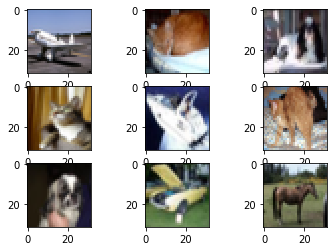

['airplane', 'cat', 'dog', 'dog', 'ship', 'frog', 'dog', 'automobile', 'horse']


In [95]:
show_imgs(x_test[-9:], 3)
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[-9:]),1)
print ([labels[x] for x in indices])

### Predict custom image

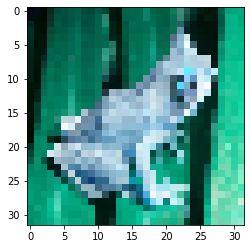

frog


In [96]:
try:
    img = cv2.imread('frog.jpg')
    img = cv2.resize(img,(32,32))
    img = np.reshape(img,[1,32,32,3])
    img = img.astype('float32')
    img = (img-mean)/std
    show_imgs(img, 1)
except Exception as e:
    print(str(e))
index = np.argmax(model.predict(img))
print(labels[index])